# Investigate ML Models

This is a simple and straightforward analysis that shows the effectiveness of this model's algorithms.

Here, we show the discriminative power of the `TokenRegressor` model, and explore several options for its construction parameters.

In [1]:
from os import chdir
import sys

# set path to allow module import
project_root = '/home/mike/litai'
if project_root not in sys.path:
    sys.path.append(project_root)

# operate in project root directory
chdir(project_root)

## Get Data

The first step is to create a dataset of positive and negative articles, pulling from actual articles provided by the Methuselah Foundation. We then split this into a training and testing subset. (A more rigorous analysis would involve cross-validation on multiple folds, but we're going to skip that.)

In [2]:
# initialize search engine to load in articles
# we already have these all downloaded, and have this really nice interface, so why not use it?

from litai import SearchEngine


engine = SearchEngine()

In [3]:
# load in positive articles
pos_pmids = open('data/senescence_pmids.txt', 'r').read().splitlines()
pos_articles = engine.search(pmids=pos_pmids, limit=None)

# show head
pos_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,30358567,2019-01-02,DNA hypermethylation within TERT promoter upre...,Replicative immortality is a hallmark of cance...,Cancer Epigenetics Oncology Telomeres
1,24182360,2013-12-01,Aging as accelerated accumulation of somatic v...,It has been postulated that aging is the conse...,
2,34431574,2021-10-01,Pathologically Responsive Mitochondrial Gene T...,Leber's hereditary optic neuropathy (LHON) is ...,Idebenone Leber's hereditary optic neuropathy ...
3,28636942,2017-06-20,Extensive Proliferation of Human Cancer Cells ...,Acquisition of replicative immortality is curr...,alternative lengthening of telomeres ever-shor...
4,34145261,2021-06-18,α-Helical peptidic scaffolds to target α-synuc...,α-Synuclein aggregation is a key driver of neu...,


In [4]:
# load in random articles to use as negatives
num_pos = pos_articles.shape[0]
num_neg = num_pos * 3  # unbalance by a factor of 3:1
neg_articles = engine.search(limit=num_neg)

# show head
neg_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,30453045,2019-03-01,Antibiotics and chemical disease-control agent...,The aquaculture industry has developed rapidly...,Antimicrobial agents Apoptosis Crayfish Immune...
1,33691720,2021-03-10,Health-related quality of life among patients ...,The mental and physical quality of life of our...,Bipolar disorder Quality of life Remission Uganda
2,34242606,2021-08-01,Medical Student Selection.,Medical school admissions committees are taske...,Admissions GPA Interviews MCAT Medical schools...
3,22173321,2012-03-01,Meta-analysis: comparison of F-18 fluorodeoxyg...,Although FDG-PET or PET/CT has higher sensitiv...,
4,32434472,2020-05-20,Mean platelet volume: a new predictor of ischa...,MPV could be a new predictor of ischaemic stro...,Atrial fibrillation CHA2DS2-VASc score Ischaem...


In [5]:
# check that pos and negative don't overlap
from numpy import intersect1d

assert(len(intersect1d(pos_articles['PMID'], neg_articles['PMID'])) < 0.01 * num_pos)

In [6]:
# split train / testing
from sklearn.model_selection import train_test_split
from numpy import concatenate, ones, zeros
from pandas import concat


# combine pos / neg articles, get labels
articles = concat((pos_articles, neg_articles))
labels = concatenate(
    (
        ones(num_pos),
        zeros(num_neg),
    )
)

# split train / test
X_train, X_test, y_train, y_test = train_test_split(articles, labels)

## Evaluate Models

Now that we have a train and test dataset, let's create a function that will let us investigate multiple underlying ML models, and show the effectiveness and metrics of each.

In [7]:
# create function to train models and plot results
from typing import Any

from matplotlib import pyplot
from matplotlib.ticker import PercentFormatter
from nptyping import NDArray
import seaborn
from sklearn.metrics import auc, precision_recall_curve, roc_curve

from litai.model import TokenRegressor


def train_model(model: Any = None) -> NDArray[(Any,), float]:
    """Train model, predict scores"""

    # train model
    kwargs = {'model': model} if model else {}
    model = TokenRegressor(**kwargs).fit(X_train, y_train)

    # use model to score articles
    y_pred = model.predict(X_test)

    # return
    return y_pred


def analyze_model(model: Any = None):

    # train model
    y_pred = train_model(model)

    # make sure plots are pretty
    seaborn.set_theme()

    # get values and metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    # plot data
    fig_height = 6
    fig, ax = pyplot.subplots(1, 2, figsize=(2*fig_height, fig_height))
    ax[0].plot(100*fpr, 100*tpr)
    ax[1].plot(100*recall, 100*precision)

    # make labels
    label_fontsize = 14
    label_args = {'fontsize': label_fontsize}
    ax[0].set_xlabel('False-Positive Rate', **label_args)
    ax[0].set_ylabel('True-Positive Rate', **label_args)
    ax[0].set_title(f'ROC-AUC = {roc_auc:.2f}', **label_args)
    ax[1].set_xlabel('Recall', **label_args)
    ax[1].set_ylabel('Precision', **label_args)
    ax[1].set_title(f'PR-AUC = {pr_auc:.2f}', **label_args)

    # format labels
    for axis in ax:
        axis.yaxis.set_major_formatter(PercentFormatter())
        axis.xaxis.set_major_formatter(PercentFormatter())
        axis.set_xlim([0, 100])
        axis.set_ylim([0, 100])

    # draw plot
    fig.tight_layout()
    pyplot.show()

Let's use this function to evaluate a linear regression, a SVM, and XGBoost.

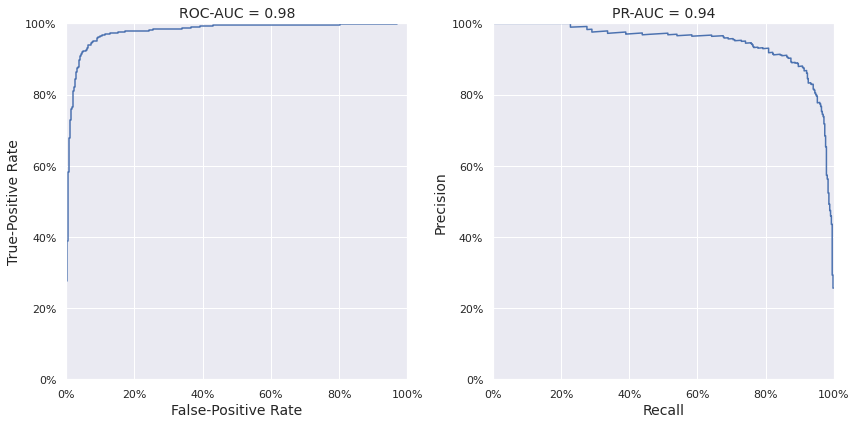

In [8]:
# try out linear regressor model
from sklearn.linear_model import LinearRegression


analyze_model(LinearRegression())

/home/mike/litai/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


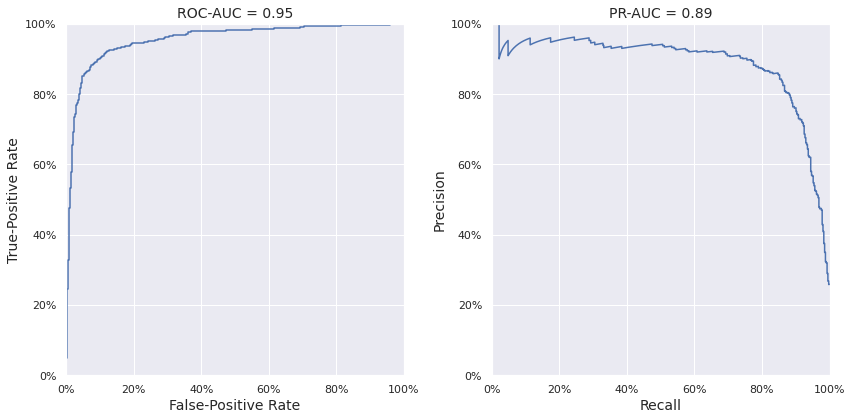

In [9]:
# try out SVM
from sklearn.svm import LinearSVR


analyze_model(LinearSVR(max_iter=1E4))

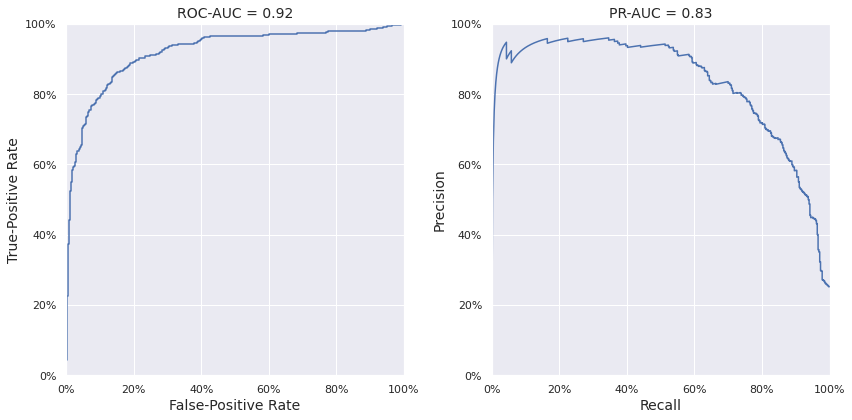

In [10]:
# try out xgboost
from xgboost import XGBRegressor


analyze_model(XGBRegressor())

## Compare to BERT

Let's compare our tokenization method to Google's BERT, using the sBERT derivative.

In [11]:
# redefine train_model() method to use BERT
from sentence_transformers import SentenceTransformer


def train_model(model: Any) -> NDArray[(Any,), float]:
    
    # use tokenizer
    text = TokenRegressor._get_text(X_train)
    encoder = SentenceTransformer('all-MiniLM-L6-v2')
    numeric = encoder.encode(text)

    # train ML model
    model.fit(numeric, y_train)

    # predict
    text = TokenRegressor._get_text(X_test)
    numeric = encoder.encode(text)
    return model.predict(numeric)

/home/mike/litai/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


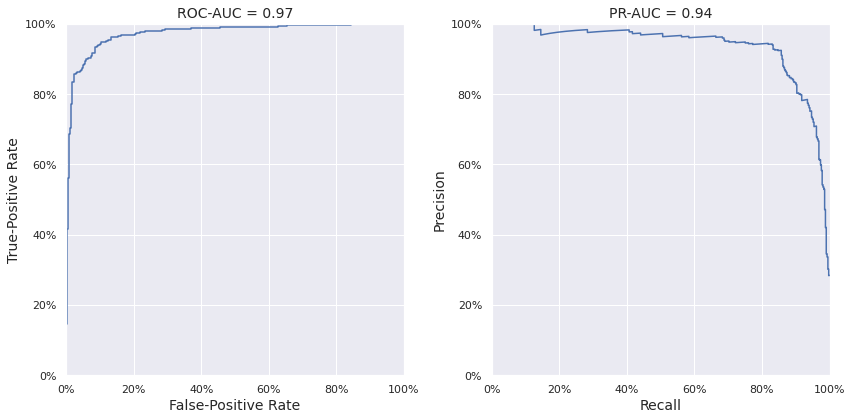

In [12]:
# try out linear regressor model
from sklearn.linear_model import LinearRegression


analyze_model(LinearRegression())

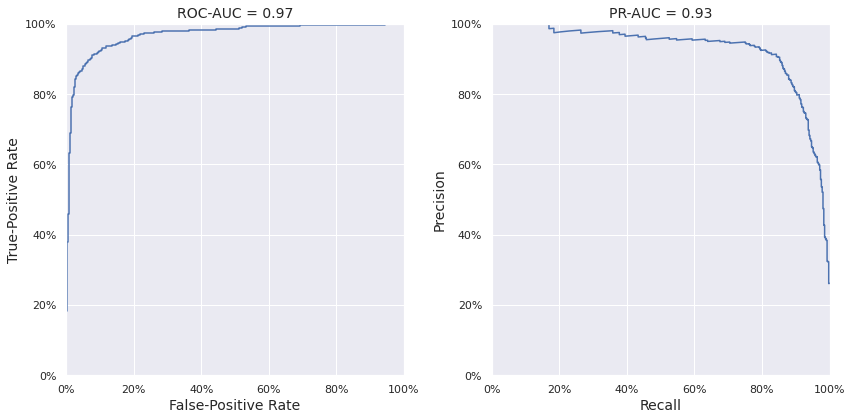

In [13]:
# try out SVM
from sklearn.svm import LinearSVR


analyze_model(LinearSVR(max_iter=1E4))

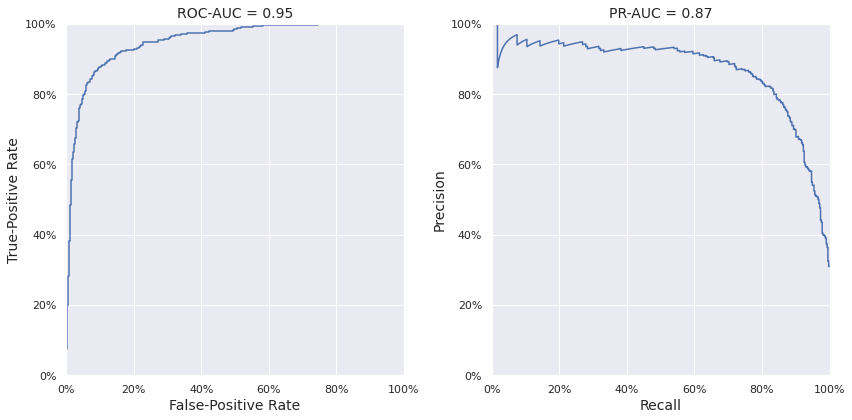

In [14]:
# try out xgboost
from xgboost import XGBRegressor


analyze_model(XGBRegressor())

## Conclusion

`LinearRegressor` is the top-performing model, and gets near-perfect accuracy.

`LinearRegressor` performs equally well with `BERT` and `vhash`, so we're going to stick with `vhash` for now, since it's faster.